In [298]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from statsmodels.tsa.api import ExponentialSmoothing, Holt, SimpleExpSmoothing
from statsmodels.tools.eval_measures import mse
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
'''
07/04/2025
Codigo ejemplo con el modelo usado por Rappy
No hay una forma de uso pues el mismo es de comparación

'''


#https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html
#################
#Declaración de variables
df_datos = pd.read_csv(r"C:/Users/alanu/Documents/Proyecto_Integrador_GITHUB_28.03.2025/BaseDeDatos/DATOSLIMPIOSRAPPI.csv",encoding='latin-1')

C:\Users\alanu\AppData\Local\Temp\ipykernel_19728\3626161222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_rappy_produccion_inicial[total_real_produccion_inicial != df_datos["Produccion Inicial Total"]] = val_corregidos


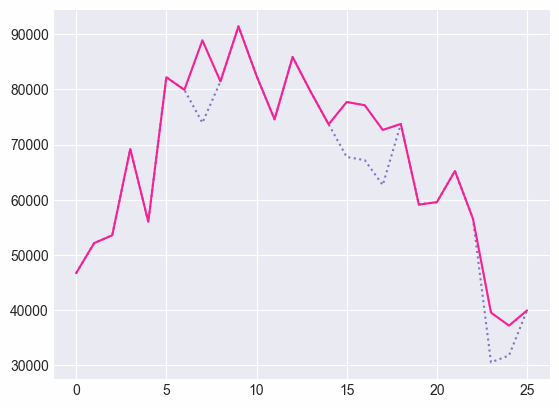

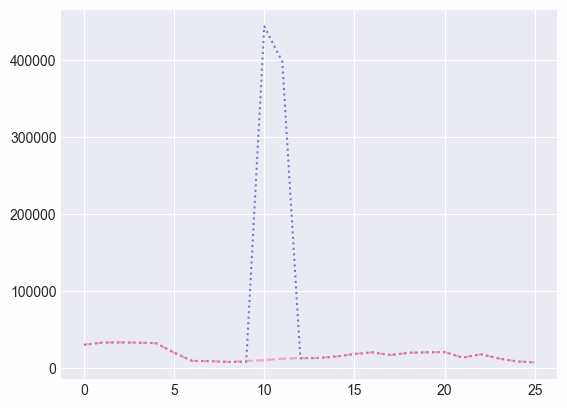

In [299]:
df_prueba_cardjolote = df_datos[["Fecha","Entregas Cardjolote Black","Produccion Inicial Cardjolote Black"]]
col_produccion_inicial = []
col_demanda = []
for i in df_datos.columns:
    if "Produccion Inicial" in i:
        col_produccion_inicial.append(i)
    if "Entregas" in i:
        col_demanda.append(i)
df_prueba_produccion_inicial = df_datos[col_produccion_inicial].copy()
df_prueba_produccion_inicial = df_prueba_produccion_inicial.drop(["Produccion Inicial Total"],axis= 1)
val_faltante = [9975 + 5000,9975,9975,5000+5000,9025,5414]
df_prueba_demanda = df_datos[col_demanda].copy()
# df_prueba_demanda = df_prueba_demanda.drop("Entrega Total",axis = 1)
s_TP = df_datos["Stocks Tarjetas Personalizadas"]
total_real_produccion_inicial = df_prueba_produccion_inicial.T.sum()
total_rappy_produccion_inicial=df_datos["Produccion Inicial Total"]

plt.figure()
plt.plot(total_rappy_produccion_inicial,linestyle= ":",label = "Datos Rappy")
val_corregidos = total_rappy_produccion_inicial[total_real_produccion_inicial != df_datos["Produccion Inicial Total"]] + np.array(val_faltante)
total_rappy_produccion_inicial[total_real_produccion_inicial != df_datos["Produccion Inicial Total"]] = val_corregidos
plt.plot(total_real_produccion_inicial,linestyle = ":", label = "Suma Real Prod Inicial")
plt.plot(df_datos["Produccion Inicial Total"], label = "Suma Corregiuda")
plt.show()


demanda_empirica_total = df_prueba_demanda.T.sum()
plt.figure()
plt.plot(demanda_empirica_total,linestyle = ":")
plt.plot(df_datos["Demanda Total Tarjetas"],linestyle = "--")
plt.plot()
val_corregidos_demanda = df_datos["Demanda Total Tarjetas"][10:12] - df_prueba_demanda[10:12].T[1:].sum()
df_datos.loc[[10,11],"Entregas Black"] = val_corregidos_demanda

In [300]:
df_demanda_black = df_datos[["Produccion Inicial Black","Entregas Black","Fecha"]].copy()
df_demanda_black = df_demanda_black.rename({"Produccion Inicial Black":"Stock_Black","Entregas Black":"Demanda_Black"},axis=1)
# df_demanda_black = pd.read_excel(r"C:/Users/alanu/Documents/Proyecto_Integrador_GITHUB_28.03.2025/BaseDeDatos/BD_Ejemplo.xlsx")
# df_demanda_black["Demanda_Black"] = df_demanda_black["Demanda_Black"] + df_demanda_black["Demanda_Black"]*0.1
train_set_demanda_black = df_demanda_black[:-6].copy()
test_set_demanda_black = df_demanda_black[-6:].copy()
s_demanda_black_suavizada =  gaussian_filter1d(np.asarray(train_set_demanda_black["Demanda_Black"]), sigma=2)
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "initial_level",
    "initial_trend",
]

In [301]:

train_set_demanda_black_holt = Holt(train_set_demanda_black["Demanda_Black"], initialization_method="estimated").fit(
    optimized=True
    )
fcast_holt = train_set_demanda_black_holt.forecast(6).rename("Holt's linear trend")

train_set_demanda_black_exponential = Holt(train_set_demanda_black["Demanda_Black"], exponential=True, initialization_method="estimated").fit(
    optimized=True
    )
fcast_exponential = train_set_demanda_black_exponential.forecast(6).rename("Exponential trend")

train_set_demanda_holt_addtive = Holt(train_set_demanda_black["Demanda_Black"], damped_trend=True, initialization_method="estimated").fit(
    optimized=True#damping_trend=0.98
)
fcast_h_additive = train_set_demanda_holt_addtive.forecast(6).rename("Additive Damped")

train_set_demanda_holt_multiplicative= Holt(
    train_set_demanda_black["Demanda_Black"], exponential=True, damped_trend=True, initialization_method="estimated"
).fit()
fcast_h_multiplicative = train_set_demanda_holt_multiplicative.forecast(6).rename("Multiplicative Damped")


c:\Users\alanu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\alanu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\alanu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\alanu\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


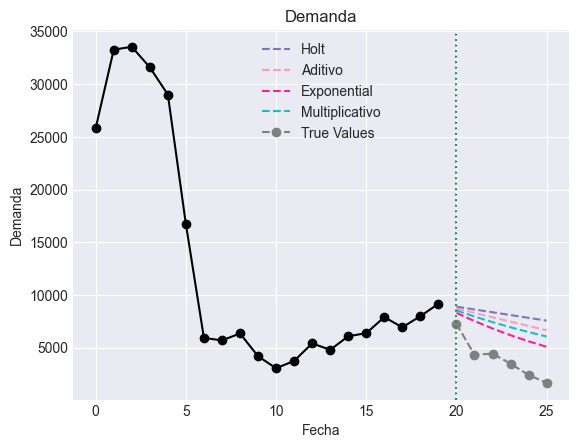

In [302]:

df_demanda_black
plt.figure()
plt.plot(train_set_demanda_black["Demanda_Black"],marker = "o",color = "black")
plt.plot(fcast_holt,linestyle = "--",label = "Holt")
plt.plot(fcast_h_additive,linestyle = "--", label = "Aditivo")
plt.plot(fcast_exponential,linestyle = "--", label = "Exponential")
plt.plot(fcast_h_multiplicative,linestyle = "--", label = "Multiplicativo")
plt.plot(test_set_demanda_black["Demanda_Black"],marker = "o",linestyle = "--",color = "gray",label = "True Values")
plt.axvline(20,linestyle = ":",color = "seagreen")
plt.title("Demanda")
plt.ylabel("Demanda")
plt.xlabel("Fecha")
plt.legend()
plt.show()

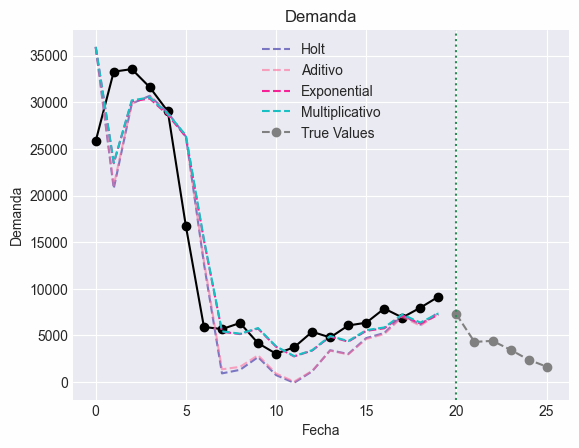

In [303]:
df_demanda_black
plt.figure()
plt.plot(train_set_demanda_black["Demanda_Black"],marker = "o",color = "black")
plt.plot(train_set_demanda_black_holt.fittedvalues,linestyle = "--",label = "Holt")
plt.plot(train_set_demanda_holt_addtive.fittedvalues,linestyle = "--", label = "Aditivo")
plt.plot(train_set_demanda_black_exponential.fittedvalues,linestyle = "--", label = "Exponential")
plt.plot(train_set_demanda_holt_multiplicative.fittedvalues,linestyle = "--", label = "Multiplicativo")

plt.plot(test_set_demanda_black["Demanda_Black"],marker = "o",linestyle = "--",color = "gray",label = "True Values")
plt.axvline(20,linestyle = ":",color = "seagreen")
plt.title("Demanda")
plt.ylabel("Demanda")
plt.xlabel("Fecha")
plt.legend()
plt.show()

In [304]:
results = pd.DataFrame(
    index=[r"Smoothing level $\alpha$ ", r" Trend $\beta$", r" Damping $\phi$", r"$l_0$", "$b_0$", "MSE"],
    columns=[ "Holt's", "Exponential", "Additive", "Multiplicative"],
)
results["Holt's"] = [train_set_demanda_black_holt.params[p] for p in params] + [mse(train_set_demanda_black_holt.fittedvalues,train_set_demanda_black["Demanda_Black"])]
results["Exponential"] = [train_set_demanda_black_exponential.params[p] for p in params] + [mse(train_set_demanda_black_exponential.fittedvalues,train_set_demanda_black["Demanda_Black"])]
results["Additive"] = [train_set_demanda_holt_addtive.params[p] for p in params] + [mse(train_set_demanda_holt_addtive.fittedvalues,train_set_demanda_black["Demanda_Black"])]
results["Multiplicative"] = [train_set_demanda_holt_multiplicative.params[p] for p in params]+ [mse(train_set_demanda_holt_multiplicative.fittedvalues,train_set_demanda_black["Demanda_Black"])]
results

,Holt's,Exponential,Additive,Multiplicative
Smoothing level $\alpha$,9.950000e-01,9.950000e-01,9.950000e-01,9.950000e-01
Trend $\beta$,1.421429e-01,1.000000e-04,1.184524e-01,1.000000e-04
Damping $\phi$,NaN,NaN,9.900000e-01,9.900000e-01
$l_0$,3.960867e+04,3.960867e+04,3.960867e+04,3.960867e+04
$b_0$,-3.709158e+03,9.063549e-01,-3.709158e+03,9.164106e-01
MSE,2.627478e+07,2.065653e+07,2.572497e+07,2.076208e+07


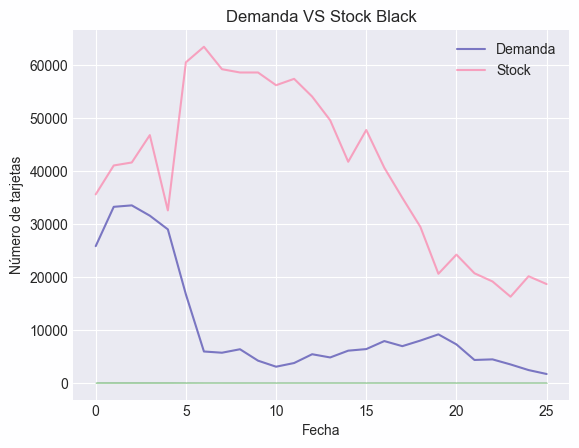

In [305]:
plt.figure()
plt.plot(df_demanda_black["Demanda_Black"],label = "Demanda")
plt.plot(df_demanda_black["Stock_Black"], label = "Stock")
plt.fill_between(range(np.size(df_demanda_black["Stock_Black"])),[0]*np.size(df_demanda_black["Stock_Black"]),
                 df_demanda_black["Demanda_Black"]/1000
                 ,color='green', alpha=0.3)
plt.xlabel("Fecha")
plt.ylabel("Número de tarjetas")
plt.title("Demanda VS Stock Black")
plt.legend()


In [306]:
df_prueba_demanda.loc[[10,11],"Entregas Black"] = val_corregidos_demanda

In [307]:
df_prueba_demanda = df_prueba_demanda[sorted(df_prueba_demanda.columns)]
df_prueba_produccion_inicial = df_prueba_produccion_inicial[sorted(df_prueba_produccion_inicial.columns)]

In [308]:
tarjetas = [i[9:] for i in df_prueba_demanda.columns]
df_prueba_delta = pd.DataFrame()

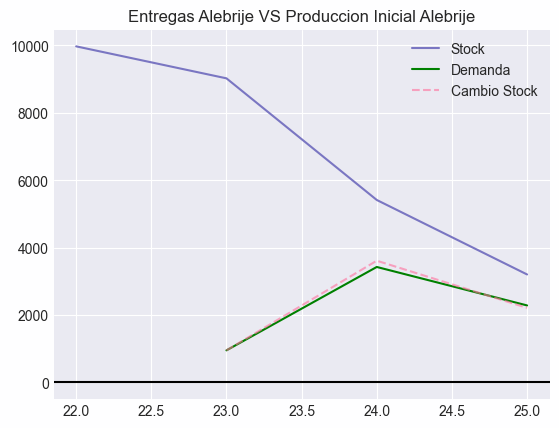

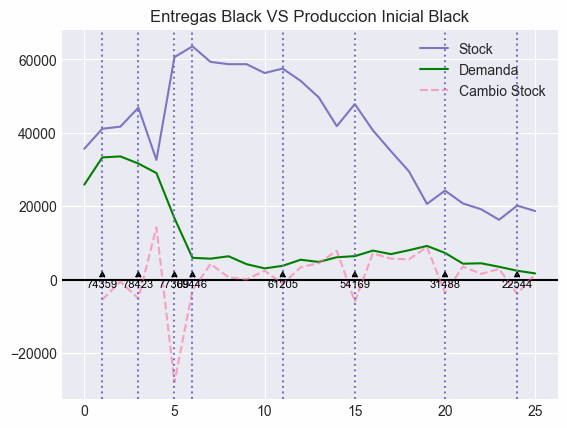

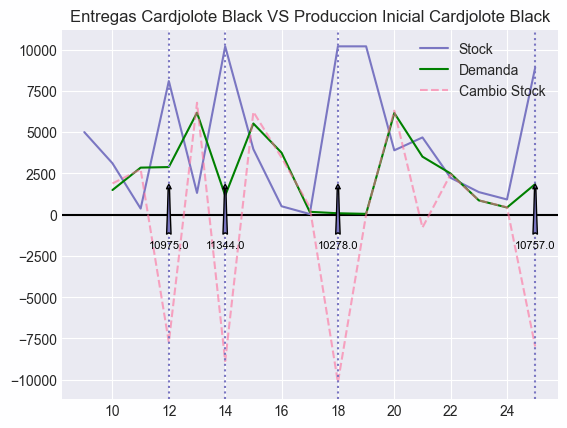

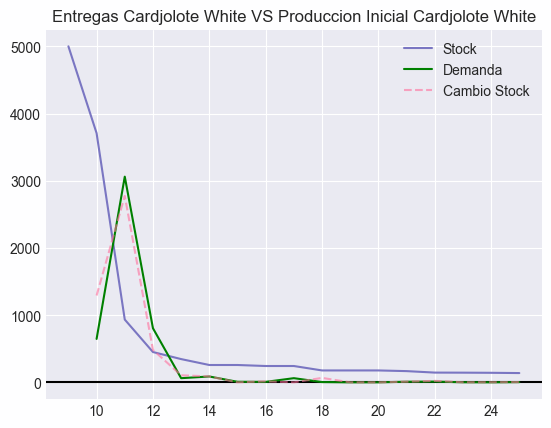

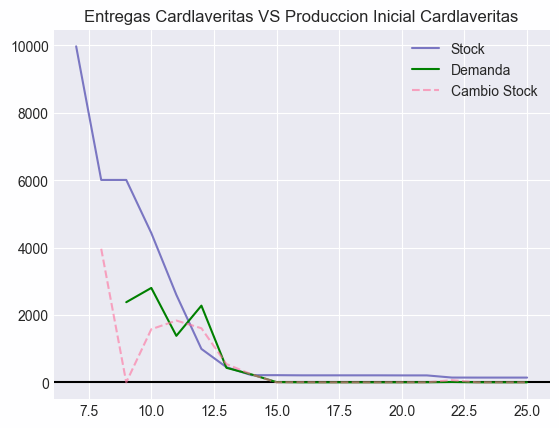

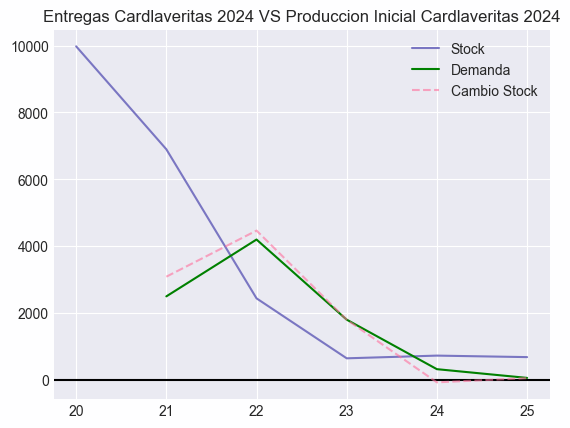

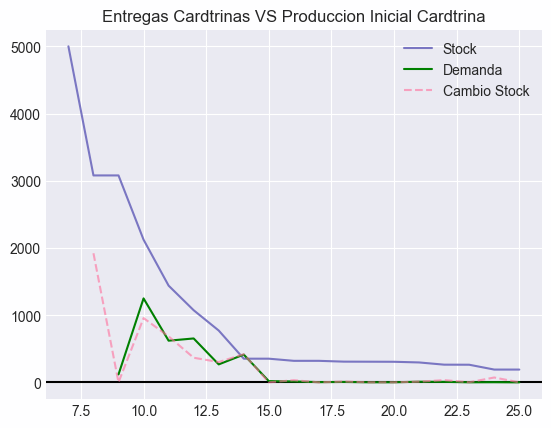

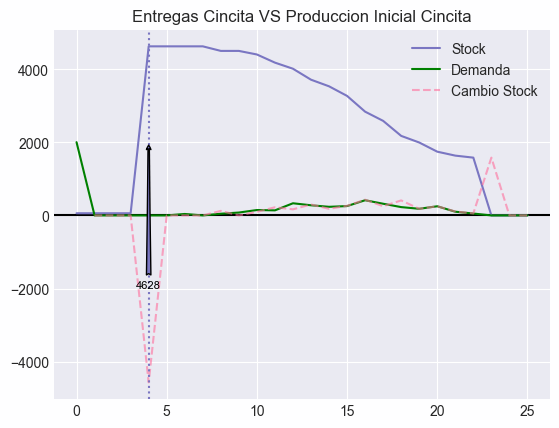

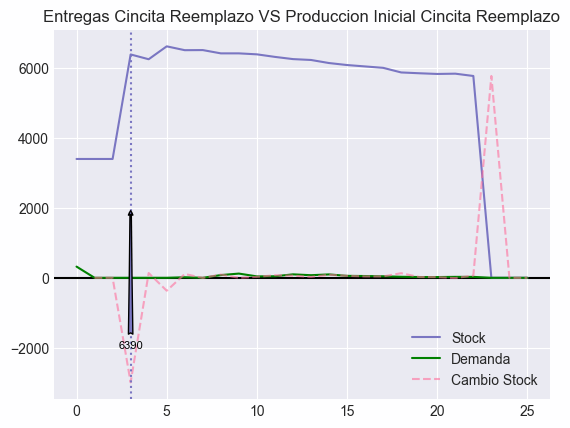

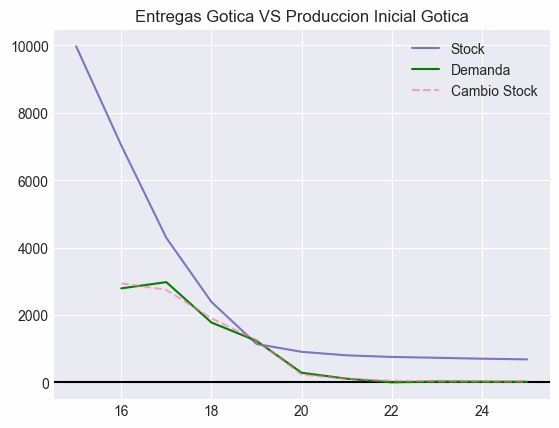

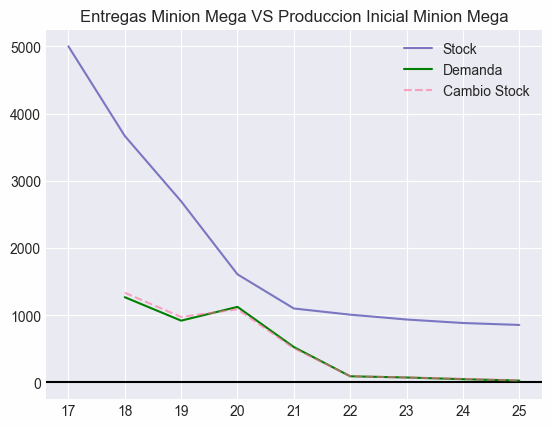

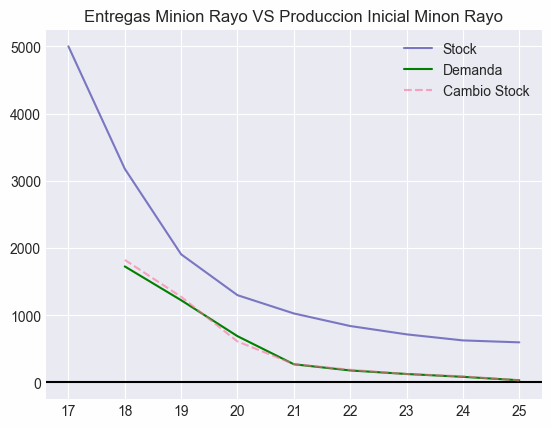

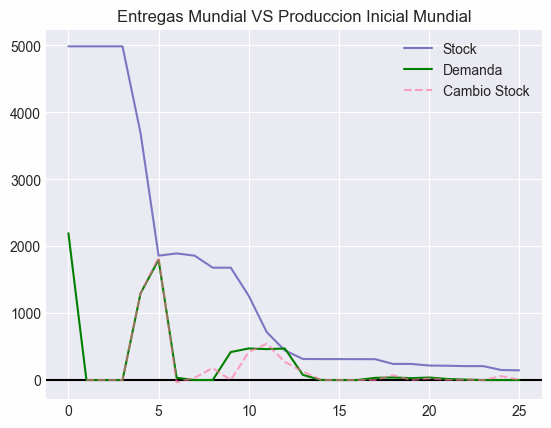

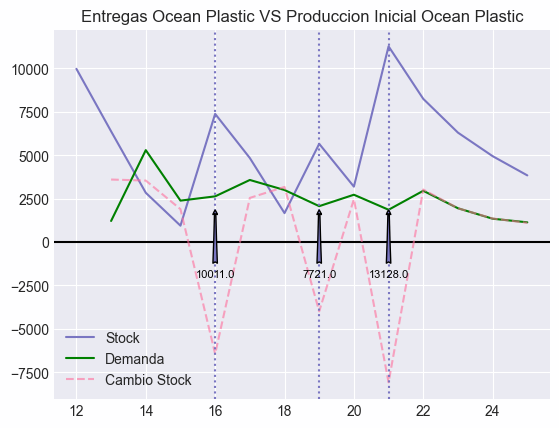

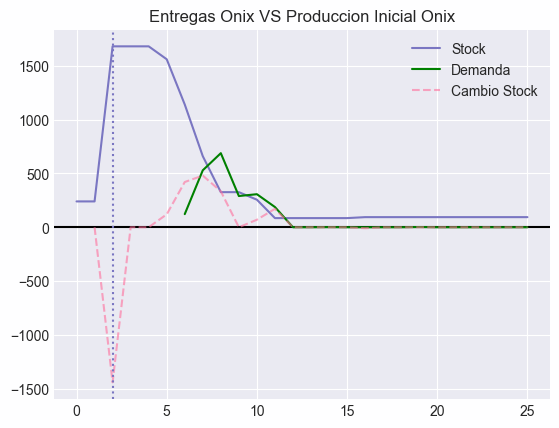

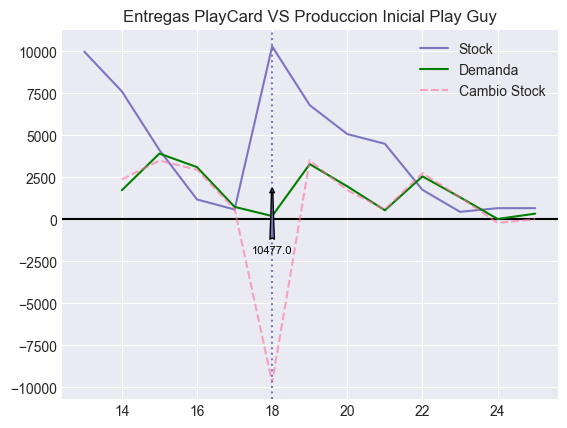

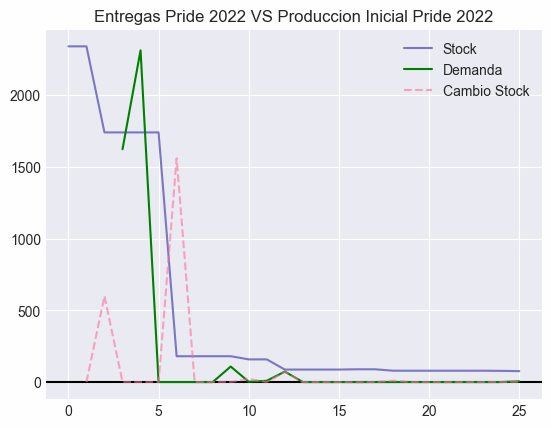

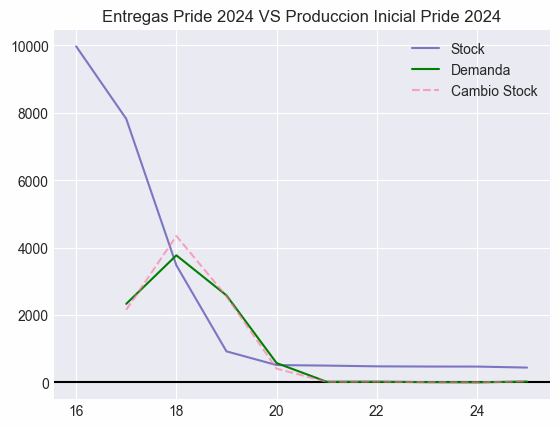

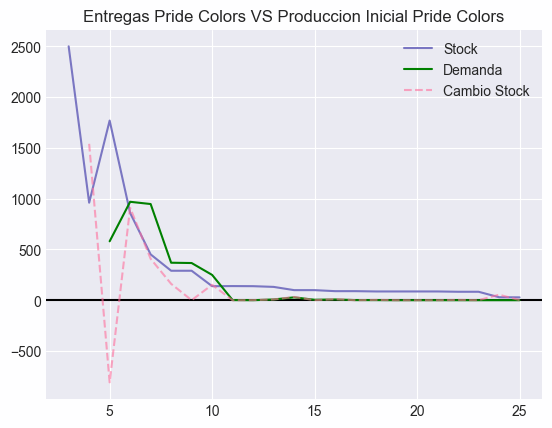

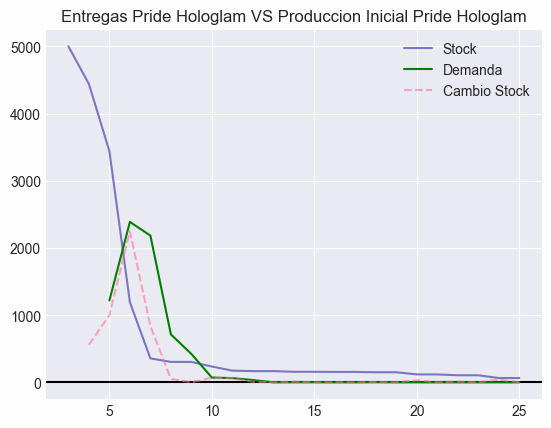

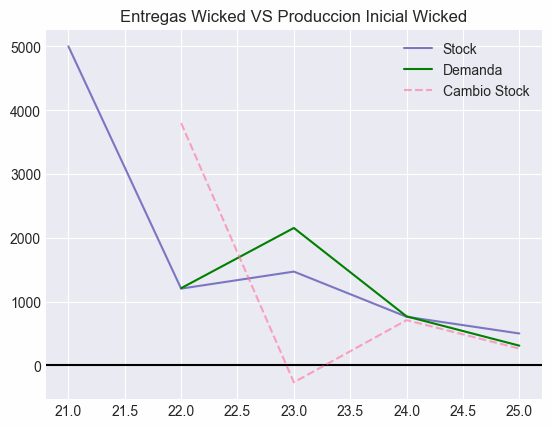

In [330]:
num = 0
for i,j in zip(df_prueba_demanda.columns,df_prueba_produccion_inicial.columns):
    cambio_stock = [np.nan]*26
    for k in range(1,len(df_prueba_produccion_inicial[j])):
        val_ant = df_prueba_produccion_inicial[j][k-1]
        cambio_stock[k] = val_ant -df_prueba_produccion_inicial[j][k]  #ANTERIO - SIGUIENTE CON EL INDICE ACTUAL
    df_prueba_delta["Cambio Stock" + tarjetas[num]] = cambio_stock
    df_aux = pd.DataFrame(cambio_stock)
    filtro_aux = np.array(cambio_stock) <-1000
    posicion_asintotas = df_aux[filtro_aux].index
    produccion_asintotas =  df_prueba_produccion_inicial[j][filtro_aux] + df_prueba_demanda[i][filtro_aux]
    plt.figure()
    plt.axhline(0, color = "black")
    plt.plot(df_prueba_produccion_inicial[j], label= "Stock")
    plt.plot(df_prueba_demanda[i], color = "green",label = "Demanda")
    plt.plot(cambio_stock, linestyle = "--",label = "Cambio Stock")
    for asintota,produccion in zip(posicion_asintotas,produccion_asintotas):
        plt.axvline(asintota,linestyle = ":")
        plt.annotate(f"{produccion}",
                xy=(asintota,2000),
                xytext=(asintota,-2000),
                arrowprops=dict(arrowstyle = "fancy"),#,shrink=0.05, width=2, headwidth=8
                ha='center', color='black',fontsize = 8)
    plt.legend()
    plt.title(i +" VS "+ j)
    plt.show()
    num +=1

    # del aux_filtro
# El batch inicial ni si quieras es creado por una demanda pronosticada para los proximos 6 mersses que son los que tienen que cubrir 
#sin eso, son solo multiplos de 2500
# Batches de menos de 100 no se vuelven a producir
# La curva de demanda, muestra pues las entregas hechas el mes pasado
# En general cada que la demanda del siguiente mes estima que lleva el inventario menos de 0 generan un nuevo batch
# Lo raro es que no lo hacen en 6 meses como es de esperarse.
# Para saber el impulso positivo
# Pues en mi punto actual = stock-demanda + PI = cambio_stock 

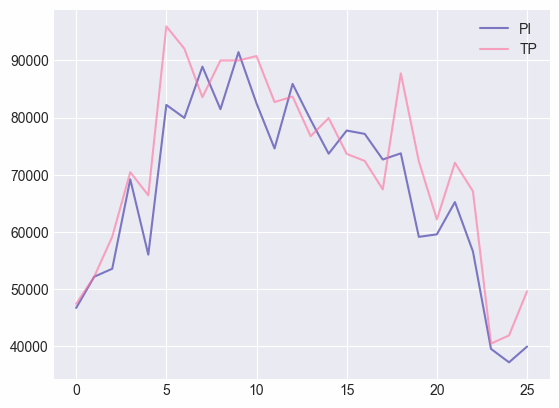

In [332]:
plt.figure()
plt.plot(df_datos["Produccion Inicial Total"],label = "PI")
plt.plot(df_datos["Stocks Tarjetas Personalizadas"],label = "TP")
plt.legend()
plt.show()

In [349]:
cambio_CB = [np.nan]*len(df_datos["Stocks Cardbody Black"])
for i in range(1,len(df_datos["Stocks Cardbody Black"])):
    cambio_CB[i] = df_datos["Stocks Cardbody Black"][i-1]-df_datos["Stocks Cardbody Black"][i]

In [350]:
df_aux = pd.DataFrame(cambio_CB)
index = np.where(df_aux <0)
# index = df_aux[filtro].index

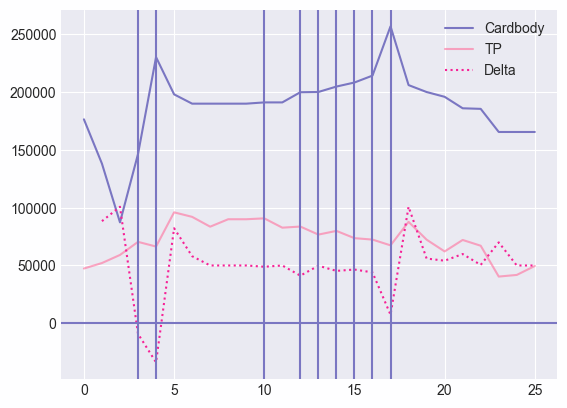

In [354]:
plt.figure()
plt.plot(df_datos["Stocks Cardbody Black"],label = "Cardbody")
plt.plot(df_datos["Stocks Tarjetas Personalizadas"],label = "TP")
plt.plot(np.array(cambio_CB)+50000,linestyle = ":", label = "Delta")
for i in index[0]:
    plt.axvline(i)
plt.axhline(0)
plt.legend()
plt.show()

In [313]:
df_prueba_entregas_mundial = pd.DataFrame()
df_prueba_entregas_mundial["Demanda Mundial"] = df_prueba_demanda["Entregas Mundial"]
df_prueba_entregas_mundial["PI Mundial"] = df_prueba_produccion_inicial["Produccion Inicial Mundial"]

In [314]:
df_prueba_entregas_mundial

val_ant = df_prueba_entregas_mundial["PI Mundial"][1]
cambio_stock = [0]*26
for i in range(1,len(df_prueba_entregas_mundial["PI Mundial"])):
    val_ant = df_prueba_entregas_mundial["PI Mundial"][i-1]
    cambio_stock[i-1] = val_ant - df_prueba_entregas_mundial["PI Mundial"][i]
df_prueba_entregas_mundial["Cambio Stock"] = cambio_stock

Demanda Mundial
PI Mundial
Cambio Stock


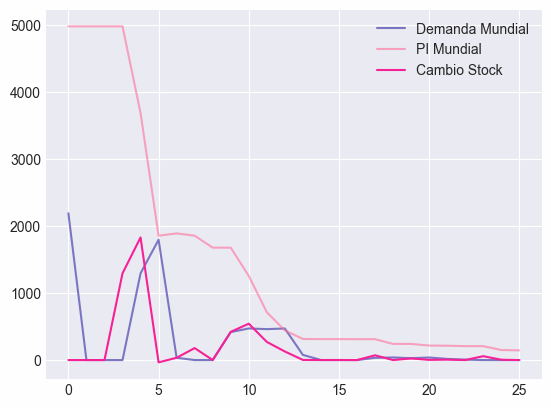

In [315]:

plt.figure()
for i in df_prueba_entregas_mundial.columns:
    print(i)
    plt.plot(df_prueba_entregas_mundial[i],label = i)
plt.legend()

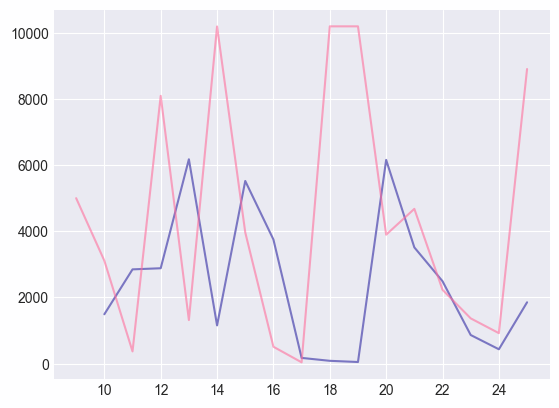

In [316]:
#  np.mean((df_demanda_black["Demanda_Black"]/1000)/df_demanda_black["Stock_Black"])

plt.plot(df_datos["Entregas Cardjolote Black"])
plt.plot(df_datos["Produccion Inicial Cardjolote Black"])